# Import package

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import sys

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

## Data preprocessing

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
scaler.fit(x_test)

x_test = scaler.transform(x_test)
y_train /= 10
y_test /= 10

# Exploratory data analysis

## correlation matrix

Visulize correlation matrix to observe which features are less relation to MEDV.

In [4]:
# correlation matrix
import seaborn as sns
import numpy as np
import pandas as pd

boston = pd.DataFrame(x_train, columns = [str(i) for i in range(13)])
boston['13'] = y_train

In [5]:
x_train.shape

(404, 13)

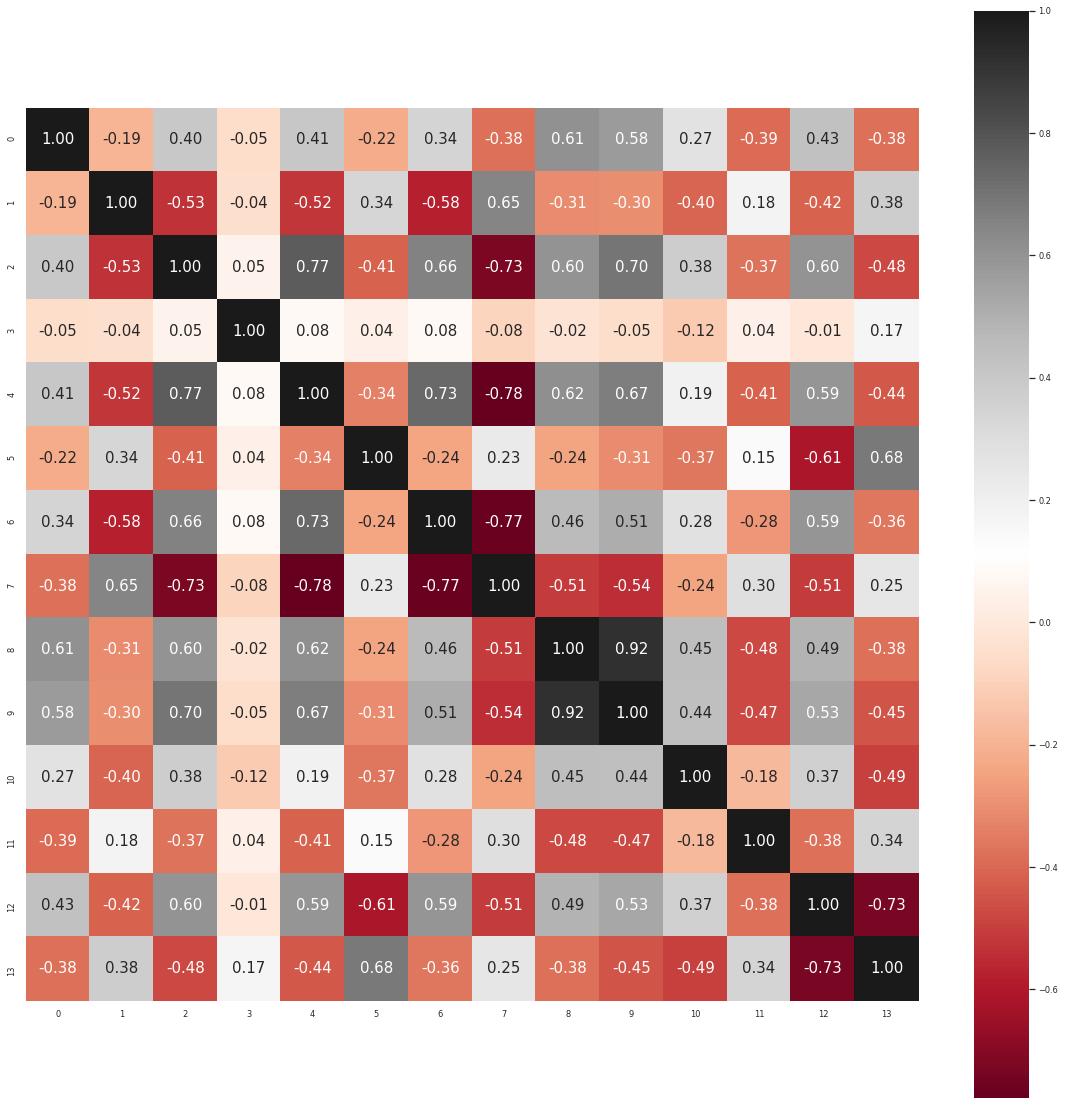

In [6]:
# correlation matrix
cm = np.corrcoef(boston.values.T)
plt.figure(figsize=(20,20))
sns.set(font_scale=0.75)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=boston.columns, xticklabels=boston.columns, cmap = 'RdGy')
plt.show()


Choose the features which r value between -0.4~~0.4, we want those feature being as independent as possible to MEDV.

So that, those features are more representative.

In [7]:
new_indexs = [i for i, e in enumerate(cm[:,12]) if e>0.2 or e<-0.2]
new_columns = boston.columns[new_indexs]

In [8]:
new_columns = new_columns[:-1]

Plot scatter plot for choosen features

<Figure size 1440x1440 with 0 Axes>

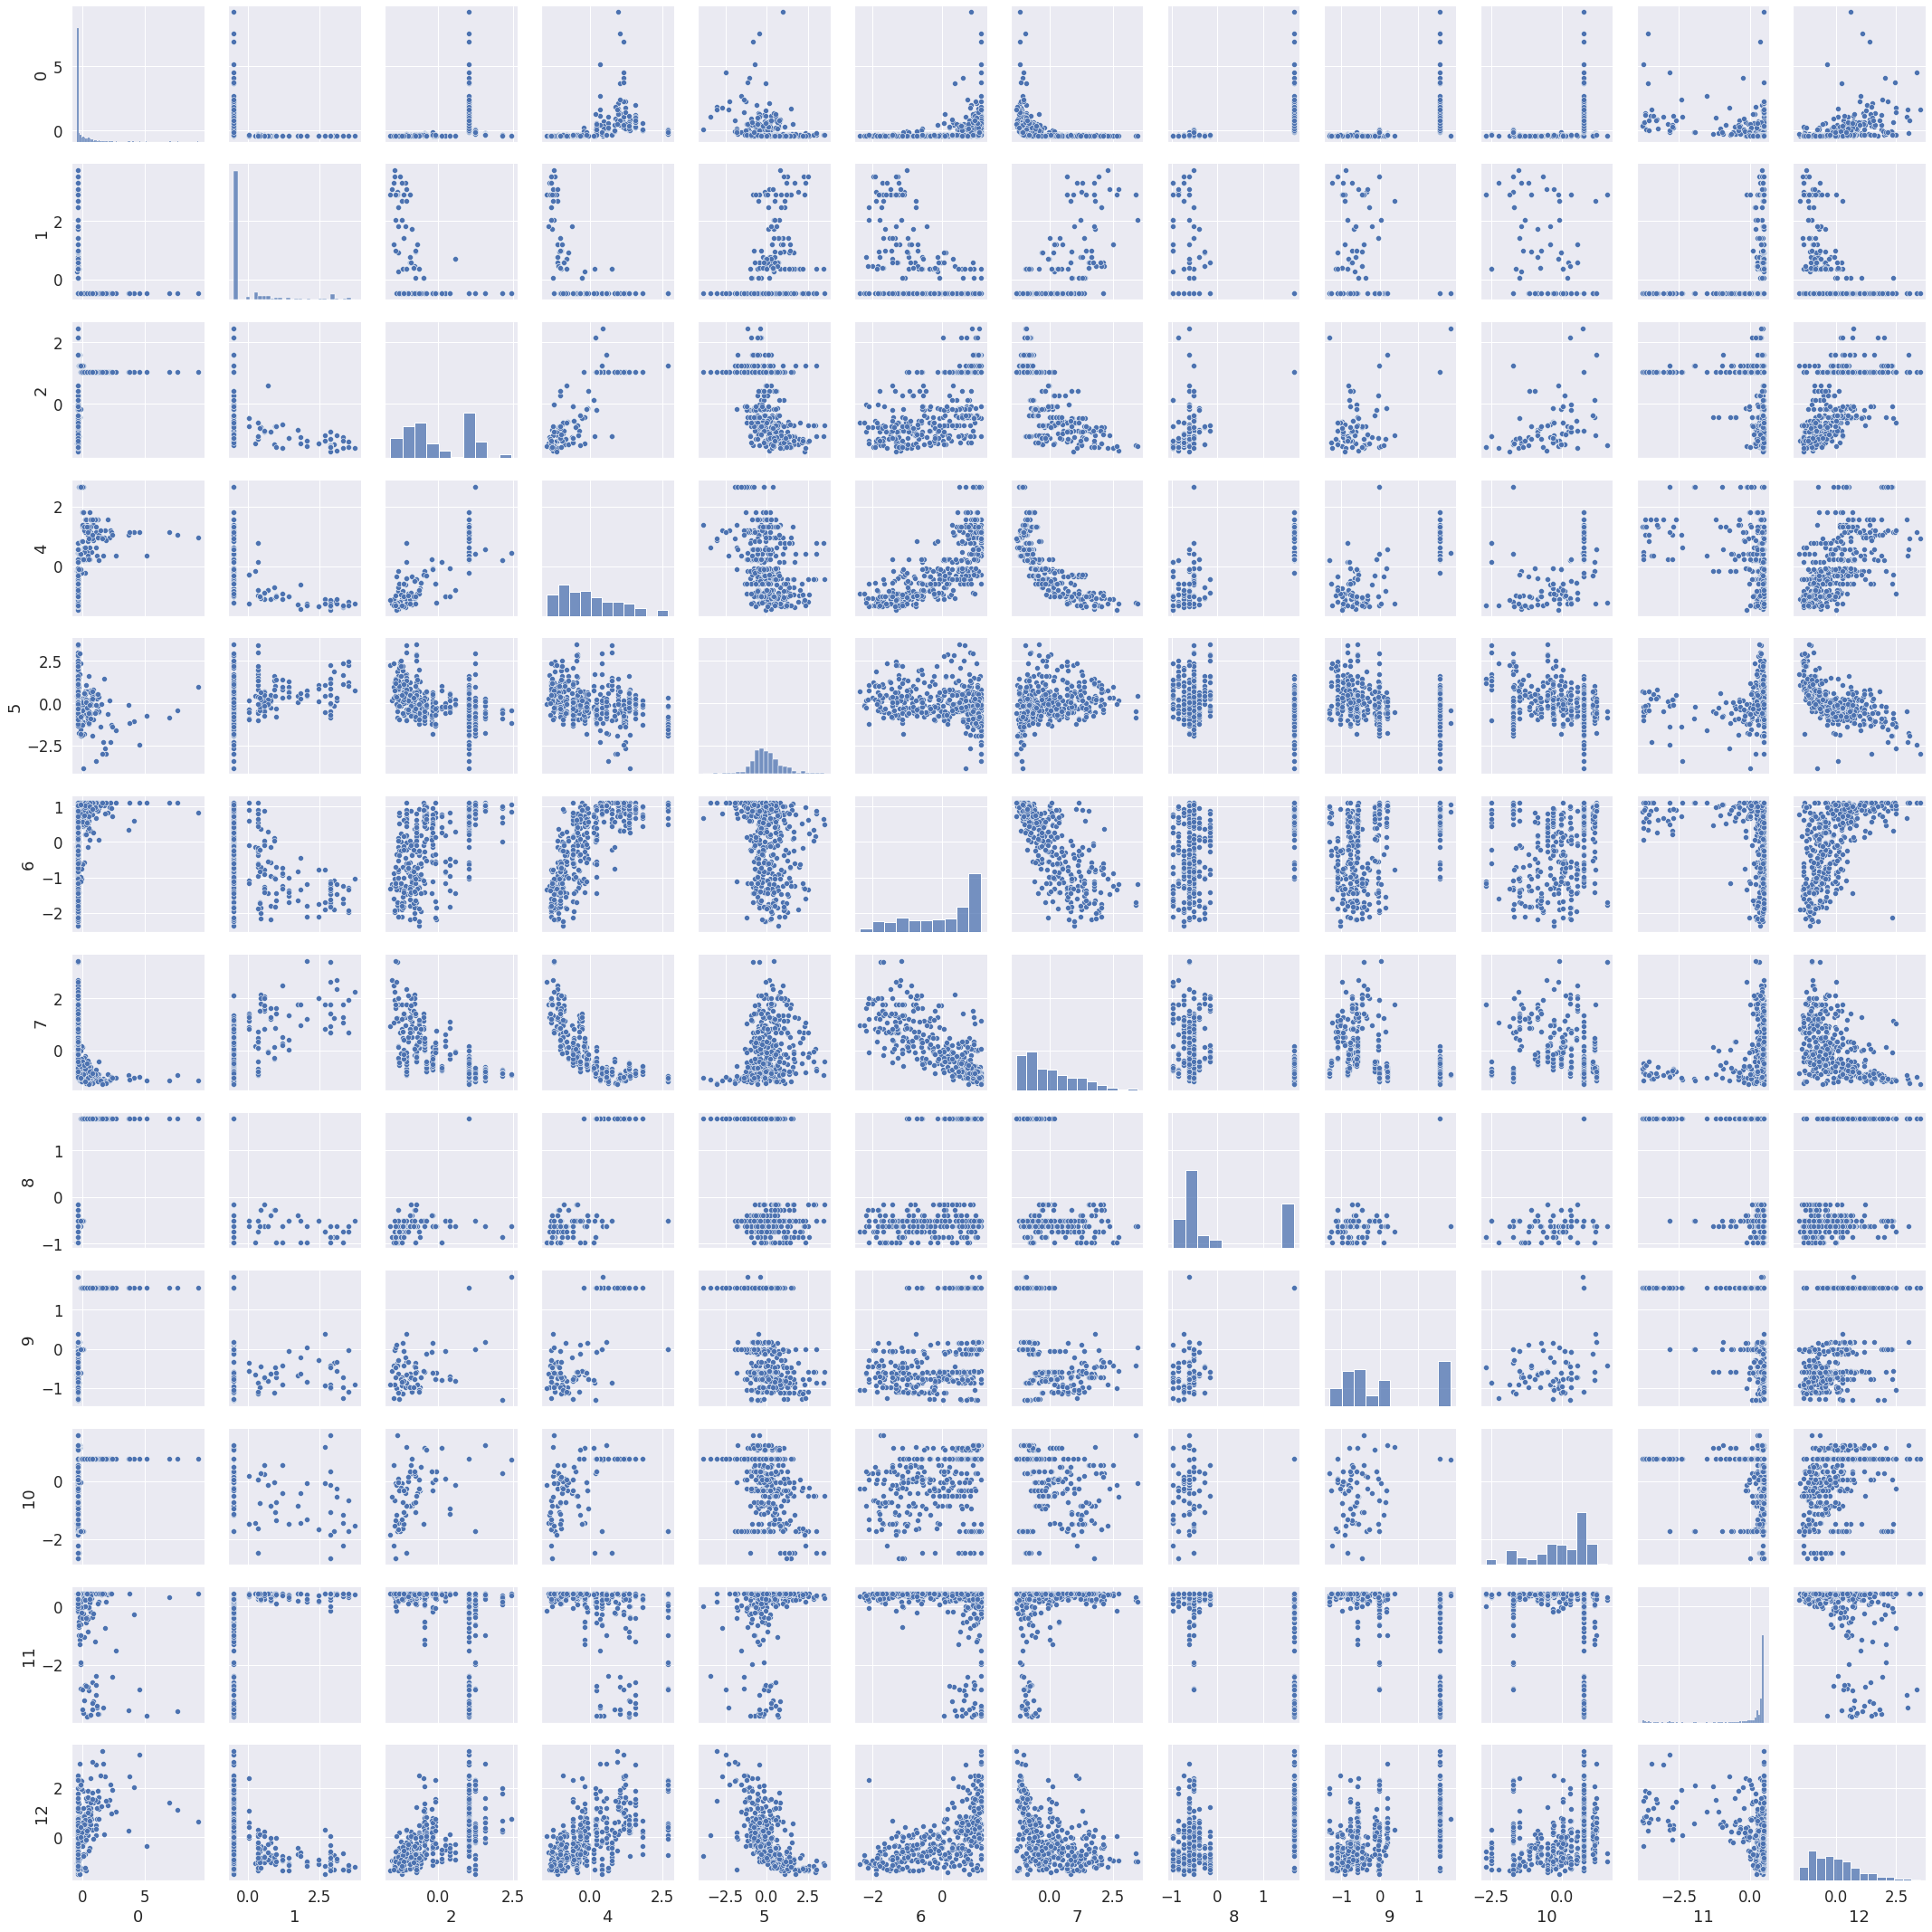

In [9]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
sns.pairplot(boston[new_columns], height=2.5)
plt.tight_layout()
plt.show()

## Chosing data

In [10]:
new_columns

Index(['0', '1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

In [11]:
new_columns= list(map(int, new_columns))
x_train = x_train[:,new_columns]
x_test = x_test[:,new_columns]

# Bulid Model and backpropagation ....

In [12]:
import numpy as np
import tensorflow as tf
import sys
class NeuralNetMLP(object):
  def __init__(self, n_hidden=30, l2=0., epochs=150, eta=0.001, shuffle=True, minibatch_size=1, seed=None, drop_out = False, Xavier_initialization = False):
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2 = l2
    self.epochs = epochs
    self.eta = eta
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size
    self.drop_out = drop_out
    self.Xavier_initialization = Xavier_initialization

  def _sigmoid(self, z):
    """Compute logistic function (sigmoid)"""
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
  
  def _Relu(self, z):
    return np.maximum(0, z)

  def _dropout(self, X):
    a = np.random.randint(2, size = X.shape)    
    while np.array_equal(a, np.zeros(shape=X.shape)):
      a = np.random.randint(2, size = X.shape)
    return a*X

  def _forward(self, X):
    """Compute forward propagation step"""
    # step 1: net input of hidden layer
    # [n_samples, n_features] dot [n_features, n_hidden]
    # -> [n_samples, n_hidden]
    if self.drop_out:
      X = self._dropout(X)
    z_h = np.dot(X, self.w_h) + self.b_h
    # step 2: activation of hidden layer
    a_h = self._Relu(z_h)
    # step 3: net input of output layer
    # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
    # -> [n_samples, n_classlabels]
    z_out = np.dot(a_h, self.w_out) + self.b_out
    # step 4: activation output layer
    a_out = self._Relu(z_out)
    return z_h, a_h, z_out, a_out

  def _compute_cost(self, y_enc, output):
    """Compute cost function.
    Parameters
    ----------
    y_enc : array, shape = (n_samples, n_labels)
    one-hot encoded class labels.
    output : array, shape = [n_samples, n_output_units]
    Activation of the output layer (forward propagation)
    Returns
    ---------
    cost : float
    Regularized cost
    """
    cost = np.sum((y_enc - output)**2)
    return cost

  def predict(self, X):
    """Predict class labels
    Parameters
    -----------
    X : array, shape = [n_samples, n_features]
    Input layer with original features.
    Returns:
    ----------
    y_pred : array, shape = [n_samples]
    Predicted class labels.
    """
    z_h, a_h, z_out, a_out = self._forward(X)
    return a_out
    
  def fit(self, X_train, y_train, X_valid, y_valid):
    """ Learn weights from training data.
    Parameters
    -----------
    X_train : array, shape = [n_samples, n_features]
    Input layer with original features.
    y_train : array, shape = [n_samples]
    Target class labels.
    X_valid : array, shape = [n_samples, n_features]
    Sample features for validation during training
    y_valid : array, shape = [n_samples]
    Sample labels for validation during training
    Returns:
    ----------
    self
    """
    n_output = 1 # no. of class labels
    n_features = X_train.shape[1]
    ########################
    # Weight initialization
    ########################
    # weights for input -> hidden
    self.b_h = np.zeros(self.n_hidden)
    
    #initializer 改這裡
    if self.Xavier_initialization:
      self.w_h = np.random.randn(n_features, self.n_hidden) / np.sqrt(n_features)
    else:
      self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))   

    # weights for hidden -> output
    self.b_out = np.zeros(n_output)

    #initializer 改這裡
    if self.Xavier_initialization:         
      self.w_out = np.random.randn(self.n_hidden, 1) / np.sqrt(self.n_hidden)
    else:
      self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
    epoch_strlen = len(str(self.epochs)) # for progr. format.
    self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
    
    # iterate over training epochs
    for i in range(self.epochs):
      #print(i)
      # iterate over minibatches
      indices = np.arange(X_train.shape[0])

      if self.shuffle:
        self.random.shuffle(indices)
      for start_idx in range(0,indices.shape[0] -self.minibatch_size +1,self.minibatch_size):
        batch_idx = indices[start_idx:start_idx+self.minibatch_size]
        # forward propagation
        z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
        ##################
        # Backpropagation
        ##################
        # [n_samples, n_classlabels]
        sigma_out = a_out - y_train[batch_idx]
        relu_derivative_h = np.zeros(len(a_h[0]))
        # [n_samples, n_hidden]         
        for i in range(len(a_h[0])):
          if a_h[0][i] > 0:
            relu_derivative_h[i] = 1
          else:
            relu_derivative_h[i] = 0
        # [n_samples, n_classlabels] dot
        # [n_classlabels, # n_hidden]
        # -> [n_samples, n_hidden]
        sigma_h = (np.dot(sigma_out, self.w_out.T)*relu_derivative_h)
        #print(X_train[batch_idx].T.shape)
        #print(np.dot(sigma_out, self.w_out.T).shape)
        # [n_features, n_samples] dot [n_samples, n_hidden]
        # -> [n_features, n_hidden]
        grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
        grad_b_h = np.sum(sigma_h, axis=0)
        # [n_hidden, n_samples] dot [n_samples, n_classlabels]
        # -> [n_hidden, n_classlabels]
        grad_w_out = np.dot(a_h.T, sigma_out)
        grad_b_out = np.sum(sigma_out, axis=0)
        # Regularization and weight updates
        delta_w_h = grad_w_h
        delta_b_h = grad_b_h # bias is not regularized
        self.w_h -= self.eta * delta_w_h
        self.b_h -= self.eta * delta_b_h
        delta_w_out = grad_w_out
        delta_b_out = grad_b_out # bias is not regularized
        self.w_out -= self.eta * delta_w_out
        self.b_out -= self.eta * delta_b_out
    return self

## fit model

drop_out = True

Xavier_initialization = True

In [13]:
MLP1 = NeuralNetMLP(drop_out = True, Xavier_initialization = True)
MLP1.n_hidden=30
MLP1.fit(X_train = x_train, y_train = y_train, X_valid = x_test, y_valid = y_test)
y_pred1 = MLP1.predict(x_test)

drop_out = True

Xavier_initialization = False

In [14]:
MLP2 = NeuralNetMLP(drop_out = True, Xavier_initialization = False)
MLP2.n_hidden=30
MLP2.fit(X_train = x_train, y_train = y_train, X_valid = x_test, y_valid = y_test)
y_pred2 = MLP2.predict(x_test)

drop_out = False

Xavier_initialization = True

In [15]:
MLP3 = NeuralNetMLP(drop_out = False, Xavier_initialization = True)
MLP3.n_hidden=30
MLP3.fit(X_train = x_train, y_train = y_train, X_valid = x_test, y_valid = y_test)
y_pred3 = MLP3.predict(x_test)

drop_out = False

Xavier_initialization = False

In [16]:
MLP4 = NeuralNetMLP(drop_out = False, Xavier_initialization = False)
MLP4.n_hidden=30
MLP4.fit(X_train = x_train, y_train = y_train, X_valid = x_test, y_valid = y_test)
y_pred4 = MLP4.predict(x_test)

# Plot

## Plot loss

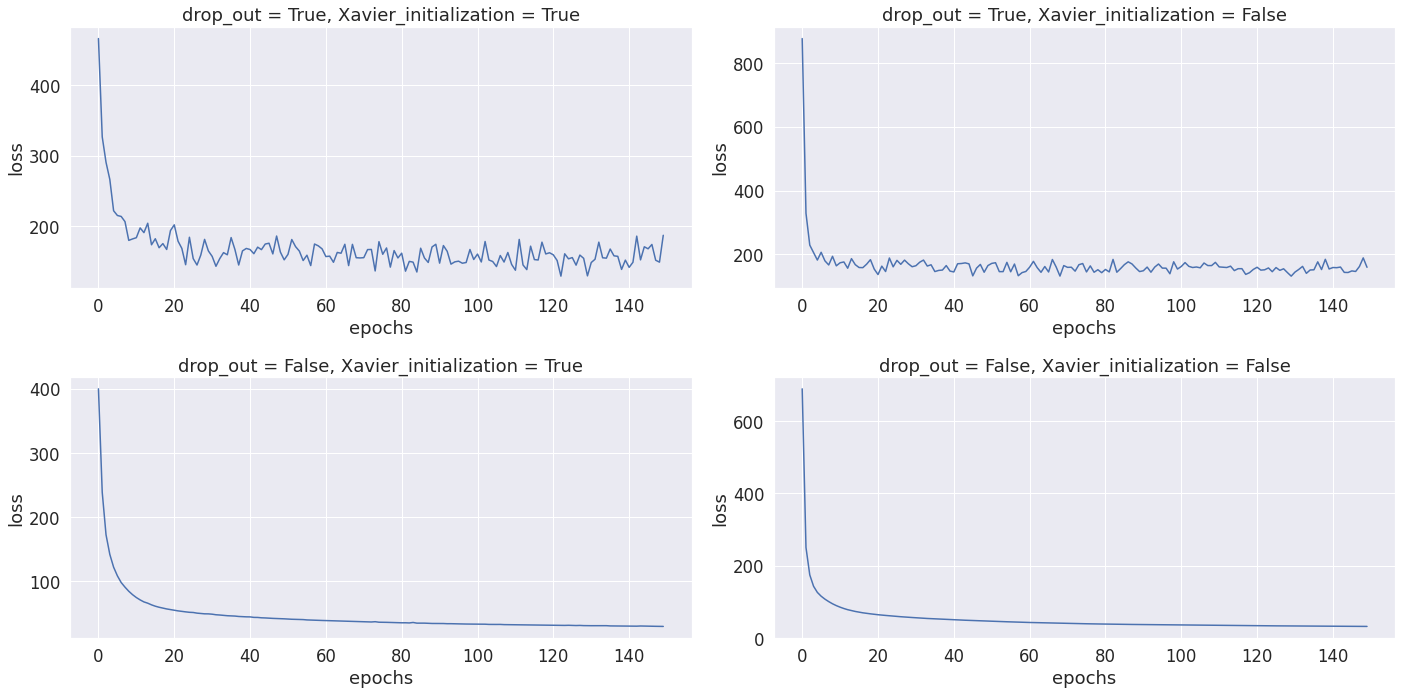

In [17]:
fig= plt.subplots(2, 2, figsize=(20, 10), sharey=True)
plt.figsize=(20, 20)
#fig.suptitle('loss function')
plt.subplot(221)
plt.title('drop_out = True, Xavier_initialization = True')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.plot(range(MLP1.epochs), MLP1.eval_['cost'])

plt.subplot(222)
plt.title('drop_out = True, Xavier_initialization = False')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(range(MLP2.epochs), MLP2.eval_['cost'])

plt.subplot(223)
plt.title('drop_out = False, Xavier_initialization = True')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.plot(range(MLP3.epochs), MLP3.eval_['cost'])

plt.subplot(224)
plt.title('drop_out = False, Xavier_initialization = False')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tight_layout()
plt.plot(range(MLP4.epochs), MLP4.eval_['cost'])

## scatter plot

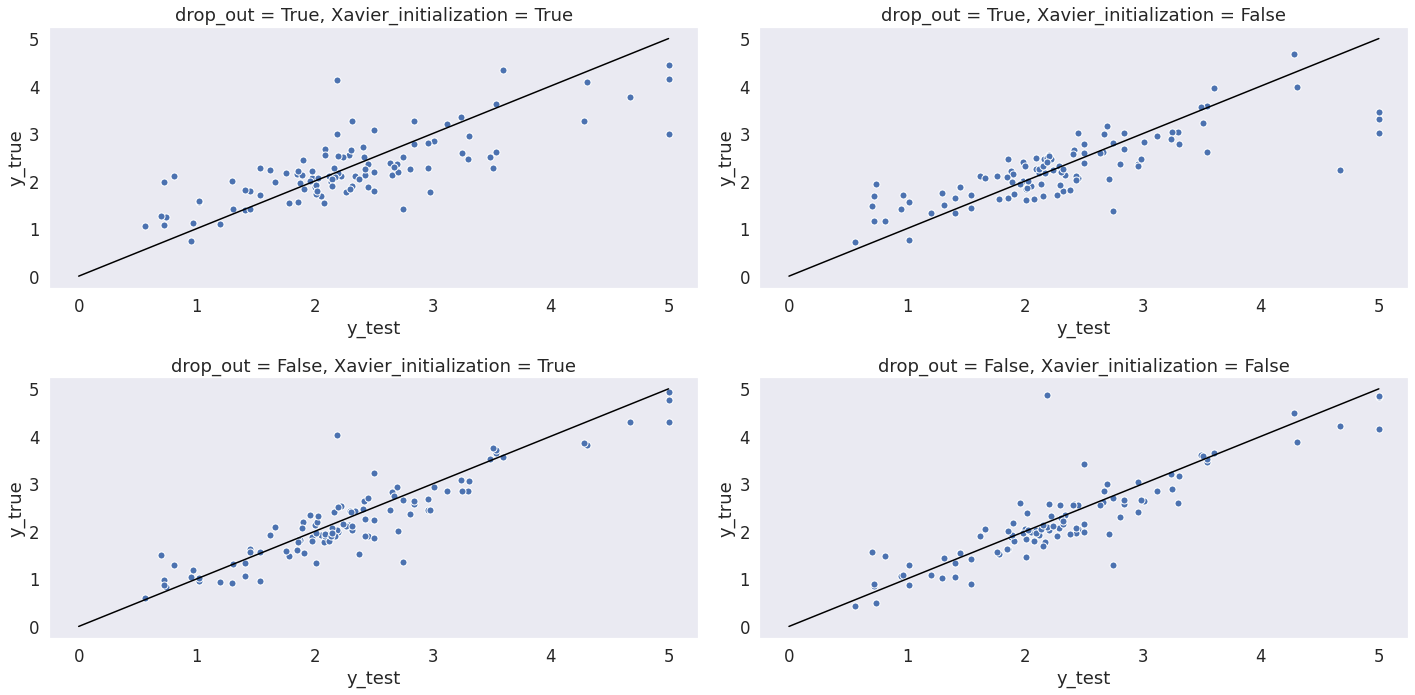

In [18]:
fig= plt.subplots(2, 2, figsize=(20, 10), sharey=True)
plt.figsize=(15,15)
x = np.linspace(0, 5,1000)

plt.subplot(221)
plt.xlabel('y_test')
plt.ylabel('y_true')
plt.title('drop_out = True, Xavier_initialization = True')
plt.scatter(y_test, y_pred1, c='b',edgecolor='white',s=50)
plt.plot(x,x,c='black')
plt.tight_layout()
plt.grid()

plt.subplot(222)
plt.xlabel('y_test')
plt.ylabel('y_true')
plt.title('drop_out = True, Xavier_initialization = False')
plt.scatter(y_test, y_pred2, c='b',edgecolor='white',s=50)
plt.plot(x,x,c='black')
plt.tight_layout()
plt.grid()

plt.subplot(223)
plt.xlabel('y_test')
plt.ylabel('y_true')
plt.title('drop_out = False, Xavier_initialization = True')
plt.scatter(y_test, y_pred3, c='b',edgecolor='white',s=50)
plt.plot(x,x,c='black')
plt.tight_layout()
plt.grid()

plt.subplot(224)
plt.xlabel('y_test')
plt.ylabel('y_true')
plt.title('drop_out = False, Xavier_initialization = False')
plt.scatter(y_test, y_pred4, c='b',edgecolor='white',s=50)
plt.plot(x,x,c='black')
plt.tight_layout()
plt.grid()

# Evaluate model

Using r2 score to evaluae model

In [19]:
from sklearn.metrics import r2_score

print(round(r2_score(y_test, y_pred1), 2), 'MLP1')
print(round(r2_score(y_test, y_pred2), 2), 'MLP2')
print(round(r2_score(y_test, y_pred3), 2), 'MLP3')
print(round(r2_score(y_test, y_pred4), 2), 'MLP4')

0.6 MLP1
0.63 MLP2
0.82 MLP3
0.77 MLP4


Using MSE to evaluate model

In [20]:
from sklearn.metrics import mean_squared_error
import math

print(round(mean_squared_error(y_test, y_pred1), 2), 'MLP1')
print(round(mean_squared_error(y_test, y_pred2), 2), 'MLP2')
print(round(mean_squared_error(y_test, y_pred3), 2), 'MLP3')
print(round(mean_squared_error(y_test, y_pred4), 2), 'MLP4')

0.33 MLP1
0.31 MLP2
0.15 MLP3
0.19 MLP4


Using MAE to evaluate model

In [21]:
from sklearn.metrics import mean_absolute_error
print(round(mean_absolute_error(y_test, y_pred1), 2), 'MLP1')
print(round(mean_absolute_error(y_test, y_pred2), 2), 'MLP2')
print(round(mean_absolute_error(y_test, y_pred3), 2), 'MLP3')
print(round(mean_absolute_error(y_test, y_pred4), 2), 'MLP4')

0.43 MLP1
0.38 MLP2
0.28 MLP3
0.28 MLP4
